Just having a quick look at the WASP-63 data, looks different

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/wasp-63/'

In [3]:
os.listdir(path)

['oeoo33010_flt.fits',
 'oeoo33010_x1d.fits',
 'oeoo33010_x2d.fits',
 'oeoo33020_crj.fits',
 'oeoo33020_flt.fits',
 'oeoo33020_sx1.fits',
 'oeoo33020_sx2.fits']

In [4]:
nuv = fits.getdata('{}oeoo33010_x1d.fits'.format(path), 1)[0]
opt = fits.getdata('{}oeoo33020_sx1.fits'.format(path), 1)[0]

(0.0, 1.5e-13)

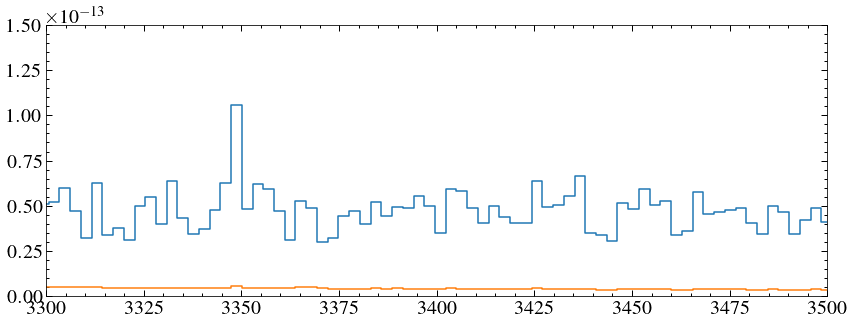

In [5]:
# plt.step(nuv['WAVELENGTH'], nuv['FLUX'])
# plt.step(nuv['WAVELENGTH'], nuv['ERROR'])
plt.step(opt['WAVELENGTH'], opt['FLUX'], zorder=-1)
plt.step(opt['WAVELENGTH'], opt['ERROR'])
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(3300, 3500)
plt.ylim(0, 1.5e-13)

In [6]:
nw, nf, ne = nuv['WAVELENGTH'],  nuv['FLUX'], nuv['ERROR']
nmask = (nw > 1980) & (nf > 0) & (nw < 3140) & (nf/ne >1)
nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
ow, of, oe = opt['WAVELENGTH'], opt['FLUX'], opt['ERROR']
omask = (ow > 3050) & (ow < 3345) | (ow > 3355) &  (ow < 5650)
ow, of, oe = ow[omask], of[omask], oe[omask]

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


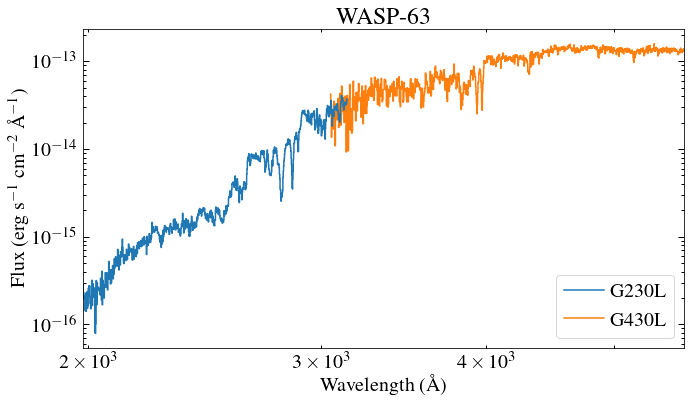

In [7]:
plt.figure(figsize=(10, 6))
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('WASP-63')
plt.xlim(1980, 5650)
plt.tight_layout()


In [8]:
import prepare_phoenix_svo as pp


Params from exoplanet archive

In [9]:
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 1.02
# teff = 5715
teff = 5475
# radius = 1.79
radius = 1.86
distance = 290.684
save_path = 'models/'
star = 'Wasp_63'
g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
pw, pf = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
normfac = ((radius*R)/(distance*u.pc.to(u.m)))**2

In [10]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

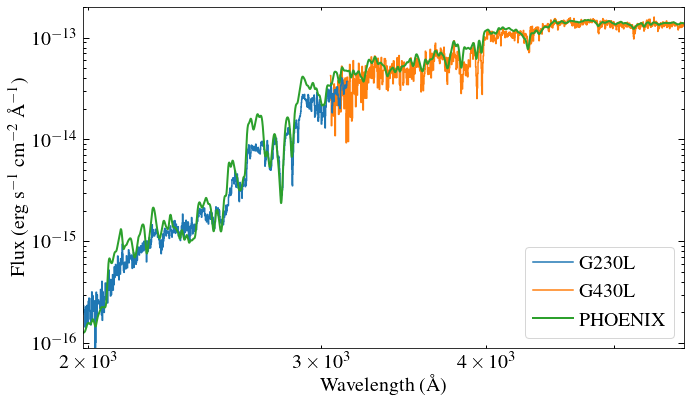

In [11]:
pmask = (pw > 1900) & (pw < 5700)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 500)
plt.figure(figsize=(10, 6))
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, lw=2, label= 'PHOENIX')
plt.legend(frameon=True, loc=4)

# plt.title('WASP-63')
plt.xlim(1980, 5650)
plt.ylim(9e-17, 2e-13)
plt.tight_layout()


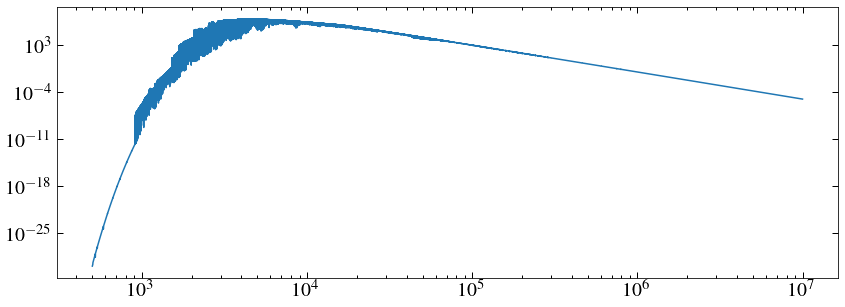

In [12]:
plt.plot(pw, pf)
plt.xscale('log')
plt.yscale('log')

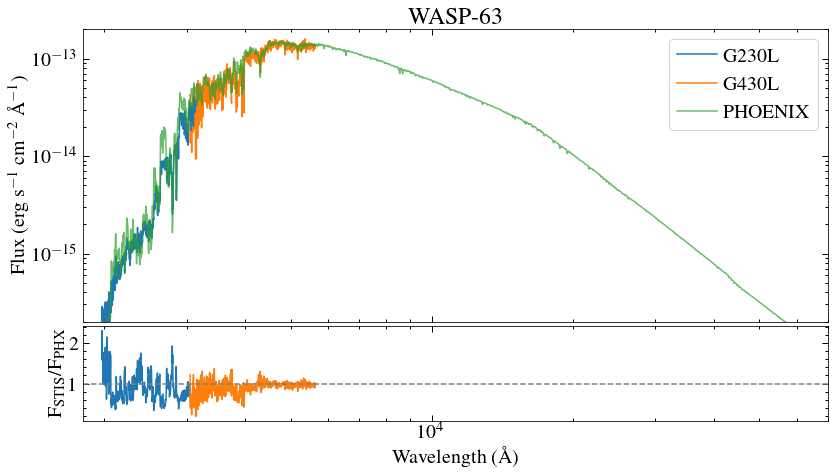

In [13]:
pwi, pfi = smear(pw, pf, 1000)
pmask = (pwi > 1600) & (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac

fig, axes = plt.subplots(figsize=(12,7))
gs = GridSpec(4, 1, figure=fig)
plt.subplot(gs[0:3])
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow, of, where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(pwi, pfi, label= 'PHOENIX', alpha=0.7)
plt.legend(frameon=True, loc=1)
plt.xticks(visible=False)
plt.title('WASP-63')
plt.xlim(1800, 70000)
plt.ylim(2e-16, 2e-13)

plt.subplot(gs[3:])
pwn, pfn = pwi[(pwi > nw[0]) & (pwi < nw[-1])], pfi[(pwi > nw[0]) & (pwi < nw[-1])]
pfn = interp1d(pwn, pfn, fill_value='extrapolate')(nw)
plt.plot(nw, nf/pfn)
pwo, pfo = pwi[(pwi > ow[0]) & (pwi < ow[-1])], pfi[(pwi > ow[0]) & (pwi < ow[-1])]
pfo = interp1d(pwo, pfo, fill_value='extrapolate')(ow)
plt.plot(ow, of/pfo)
plt.axhline(1, ls='--', c='0.5')
plt.xlim(1800, 70000)
plt.xscale('log')

plt.xlabel('Wavelength (\AA)')
plt.ylabel('F$_{\mathrm{STIS}}$/F$_{\mathrm{PHX}}$')
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/WASP-63_stis_v_phoenix.png', facecolor= 'w')

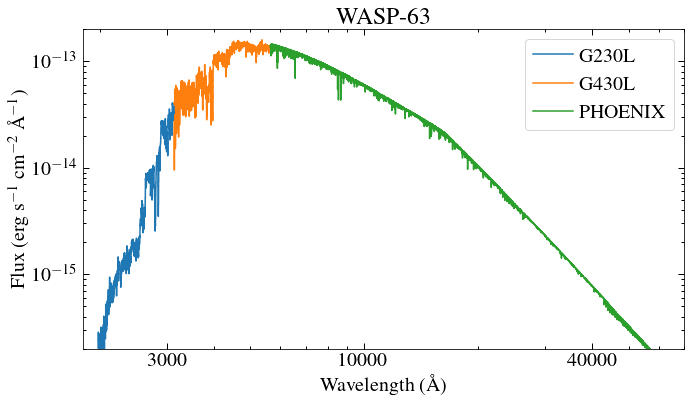

In [14]:
pwi, pfi = smear(pw, pf, 10000)
pmask = (pwi > 5650) & (pwi < 100000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac

fig, axes = plt.subplots(figsize=(10,6))
# gs = GridSpec(4, 1, figure=fig)
# plt.subplot(gs[0:3])
plt.step(nw, nf, where='mid', label= 'G230L')
# plt.step(nw, ne, where='mid', label= 'G230L')
plt.step(ow[(ow > nw[-1])], of[(ow > nw[-1])], where='mid', label='G430L', zorder=-1)
# plt.xlim(3200, 3400)
plt.xscale('log')
plt.yscale('log')

plt.plot(pwi, pfi, label= 'PHOENIX')
# plt.plot(pw[pw> 5650], pf[pw> 5650]*normfac, label= 'PHOENIX')
plt.legend(frameon=True, loc=1)
plt.title('WASP-63')
plt.xlim(1800, 70000)
plt.ylim(2e-16, 2e-13)
plt.xticks((3000, 10000, 40000), (3000, 10000, 40000))


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('plots/WASP-63_ql.png', facecolor= 'w')